# Exercise 10 - Solution

- In this exercise we will train a neural net to learn the two spirals dataset from [SyntheticDatasets.jl](https://github.com/ATISLabs/SyntheticDatasets.jl).

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(["Flux", "IJulia", "Optimisers", "Plots"])

  Activating project at `~/code/TUM-Dynamics-Lecture/exercises/exercise-10`
   Resolving package versions...
  No Changes to `~/code/TUM-Dynamics-Lecture/exercises/exercise-10/Project.toml`
  No Changes to `~/code/TUM-Dynamics-Lecture/exercises/exercise-10/Manifest.toml`


In [2]:
using Flux, Optimisers, LinearAlgebra, Plots, Printf, IJulia

In [3]:
"""
    make_twospirals(;    n_samples::Int = 2000,
                             start_degrees::Int = 90,
                             total_degrees::Int = 570,
                             noise::Float64 = 0.2
Generate two spirals dataset. Return a Nx3 matrix, where each line contains the X,Y coordinates and the class of an instance.
# Arguments
- `n_samples::Int = 2000`: The total number of points generated.
- `start_degrees::Int = 90`: Determines how far from the origin the spirals start.
- `total_degrees::Int = 570`: Controls the lenght of the spirals.
- `noise::Float64 = 0.2`: Determines the noise in the dataset.
Reference: [SyntheticDatasets.jl](https://github.com/ATISLabs/SyntheticDatasets.jl)
Reference: [link](https://la.mathworks.com/matlabcentral/fileexchange/41459-6-functions-for-generating-artificial-datasets)
"""
function make_twospirals(; n_samples::Int = 2000,
                               start_degrees::Int = 90,
                               total_degrees::Int = 570,
                               noise::Float64 = 0.2)
   start_degrees = deg2rad(start_degrees);

   N1 = floor(Int, n_samples / 2);
   N2 = n_samples - N1;

   n = start_degrees .+ sqrt.(rand(N1,1)) .* deg2rad(total_degrees);
   d1 = [-cos.(n).*n + rand(N1,1).*noise sin.(n).*n+rand(N1,1).*noise];

   n = start_degrees .+ sqrt.(rand(N2,1)) .* deg2rad(total_degrees);
   d2 = [cos.(n).*n+rand(N2,1)*noise -sin.(n).*n+rand(N2,1)*noise];

   features = [d1; d2]
   labels = [zeros(Int, N1); ones(Int, N2)]

   return (features, labels)
end

make_twospirals

In [4]:
# Generate the data
X, y = make_twospirals(
    n_samples = 1000, 
    start_degrees = 90,
    total_degrees = 630, 
    noise = 1.0,
)

([-2.765242184961891 -4.054089589682772; 10.319011623714959 0.05380821144917736; … ; -3.959389713510652 9.635385396936417; 2.489581104215101 5.488845155229727], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

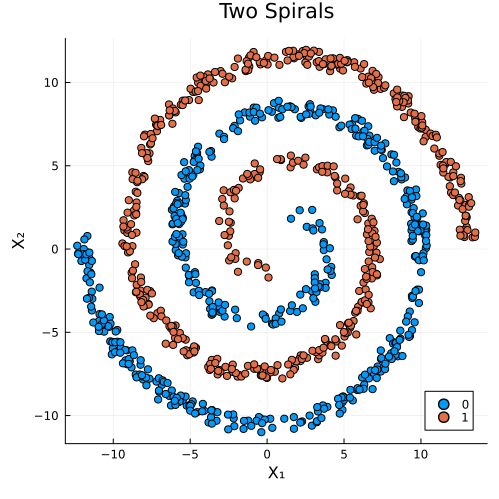

In [5]:
# Plot
scatter(X[:,1], X[:,2], group = y, xlabel = "X₁", ylabel = "X₂", title = "Two Spirals", size = (500, 500))

1. Follow Task 1 and Task 2 in this interactive [notebook](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/playground-exercises#neural-net-spiral) to experiment with many different model setups, varying the number of layers, the width of the layers, and the regularisation.

2. Once you're satisfied with your test error for a given model setup, implement and train that model in Julia using Flux. Note that the noise parameters in the notebook and the SyntheticDatasets library are not equivalent, so just try to use values of the parameters which result in visually similar datasets. Remember to split the data into training and test sets. Is the test error of your implementation comparable to the one in the notebook?

## Solution

In [6]:
"""
    plot_training(train_loss, test_loss, epochs)

Plot the training loss and test loss as training progresses.
"""
function plot_training(train_loss, test_loss, epoch, epochs)
    plt = plot(
        train_loss, 
        label = "train_loss", 
        xlabel = "epoch", 
        ylabel = "loss", 
        size = (800, 500), 
        xlims = (0, epochs), 
        right_margin = 3Plots.mm,
        title = @sprintf "epoch = %i, test_loss = %.2f" epoch test_loss[end]
    )
    plot!(plt, test_loss, label = "test_loss")
    IJulia.clear_output(true)  # Clear the old plot
    display(plt)    
end

plot_training

In [7]:
"""
    train_spiral(X, y; epochs = 1000, width = 20, activation = σ, η = 0.1, λ = 0.0)

Train a neural net with a single hidden layer on the data in X and y.

We use a sigmoid activation function by default because it saturates at 0 and 1, 
and is therefore suitable for the two spirals data we wish to learn.
"""
function train_spiral(X, y; epochs = 1000, width = 30, activation = σ, η = 0.1, λ = 0.0)
    # 1. Feature engineering
    #X = vcat(X, X.^2, sin.(X), (X[1, :] .* X[2, :])')
    
    # 2. Train-test split
    (X_train, y_train), (X_test, y_test) = Flux.splitobs((X, y), at = 0.7, shuffle = true)
    
    # 3. Set up the model
    n_features = size(X)[1]  # Will be 2 unless we do some feature engineering
    hidden_layer = Dense(n_features, width, activation)
    output_layer = Dense(width, 1, activation)
    mlp = Chain(hidden_layer, output_layer)
    
    # 4. Define the loss function
    loss(m, X, y) = Flux.mse(m(X)[1,:], y)
    
    # 5. Choose an optimiser and a learning rate, together with weight decay
    # See the Flux docs for an explanation of this approach to regularisation
    # https://fluxml.ai/Flux.jl/stable/training/training/#Regularisation
    opt_state = Optimisers.setup(
        Optimisers.OptimiserChain(
            Optimisers.WeightDecay(λ),
            Optimisers.Adam(η),
        ),    
        mlp,
    )

    # 6. Train
    train_loss = []
    test_loss = []
    for epoch in 1:epochs
        Flux.train!(loss, mlp, [(X_train, y_train)], opt_state)
        
        # Record and plot the loss
        push!(train_loss, Flux.mse(mlp(X_train)[1,:], y_train))
        push!(test_loss, Flux.mse(mlp(X_test)[1,:], y_test))
        plot_training(train_loss, test_loss, epoch, epochs)
    end
end

train_spiral

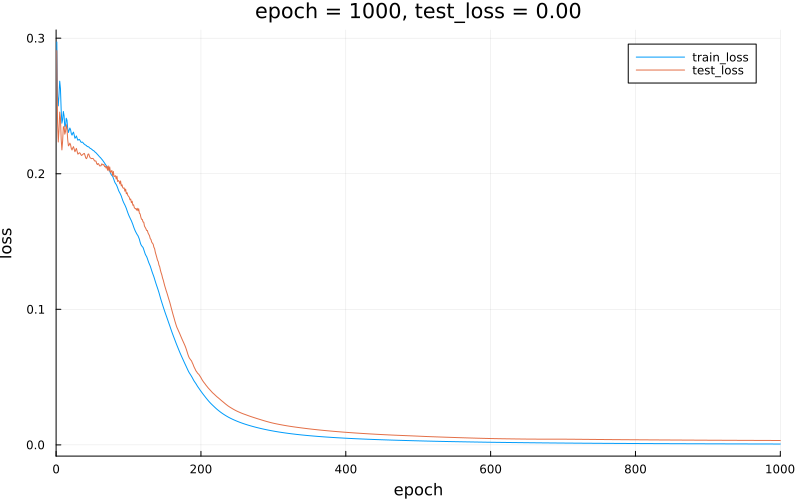

In [8]:
train_spiral(X', y)

Since there's very little noise in the data, the two categories are well separated and we can easily learn to distinguish between them. Let's try adding some noise.

In [9]:
X, y = make_twospirals(noise = 2.0);

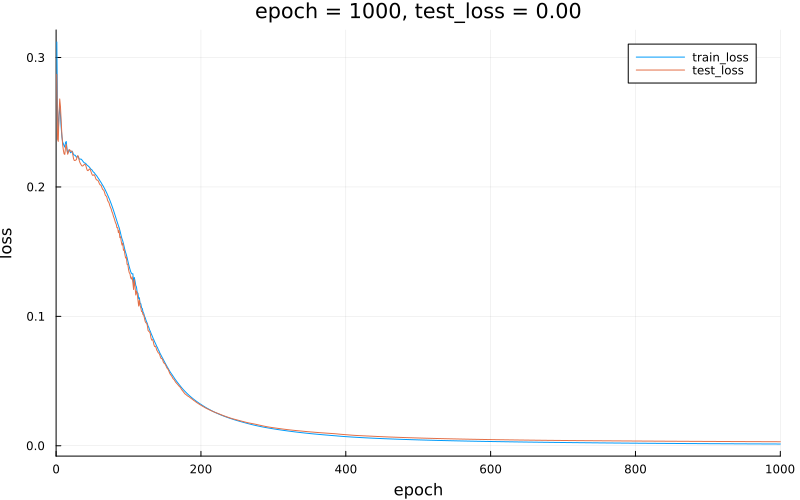

In [10]:
train_spiral(X', y)

This is similar to what we had before. Let's try adding even more noise.

In [11]:
X, y = make_twospirals(noise = 3.0);

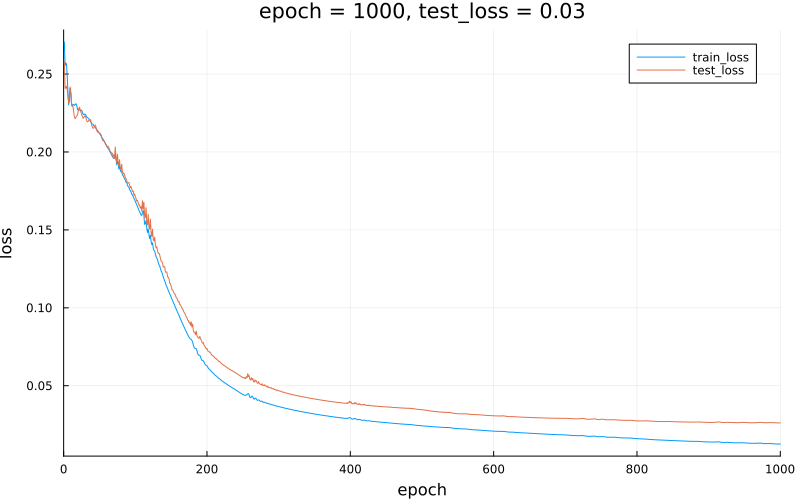

In [12]:
train_spiral(X', y)

We can now see that the model is having some difficulty closing the gap between the training error and the test error due to the noise. Try playing around with the model capacity (by changing the width of the hidden layer or by adding more layers) and also with different amounts of regularisation to see if you can reduce the test error further.